2025-10-26 08:16:08.365719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761466568.610121      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761466568.676513      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading model from /kaggle/input/old-dataset-model/keras/default/1/best_oasis_model.keras...


I0000 00:00:1761466583.978488      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761466583.979162      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model loaded successfully.
Loading labeled test data from /kaggle/input/adni-mendeley-dataset/Adni_mendeley_dataset/Adni_mendeley_dataset...
Found 6399 files belonging to 4 classes.
Found 6399 images in 4 classes.
Making predictions on test set...


I0000 00:00:1761466593.025614      63 service.cc:148] XLA service 0x7f1898005c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761466593.026586      63 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761466593.026605      63 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761466593.153682      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


 15/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

I0000 00:00:1761466594.718337      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step

--- Classification Report ---
                    precision    recall  f1-score   support

     Mild Dementia       0.91      1.00      0.95       895
 Moderate Dementia       0.98      1.00      0.99        64
      Non Demented       1.00      0.97      0.99      3200
Very mild Dementia       0.98      0.97      0.98      2240

          accuracy                           0.98      6399
         macro avg       0.97      0.99      0.98      6399
      weighted avg       0.98      0.98      0.98      6399


--- Confusion Matrix ---
[[ 892    0    0    3]
 [   0   64    0    0]
 [  40    1 3115   44]
 [  52    0    6 2182]]
Generating confusion matrix plot...
Confusion matrix plot saved as: confusion_matrix.png


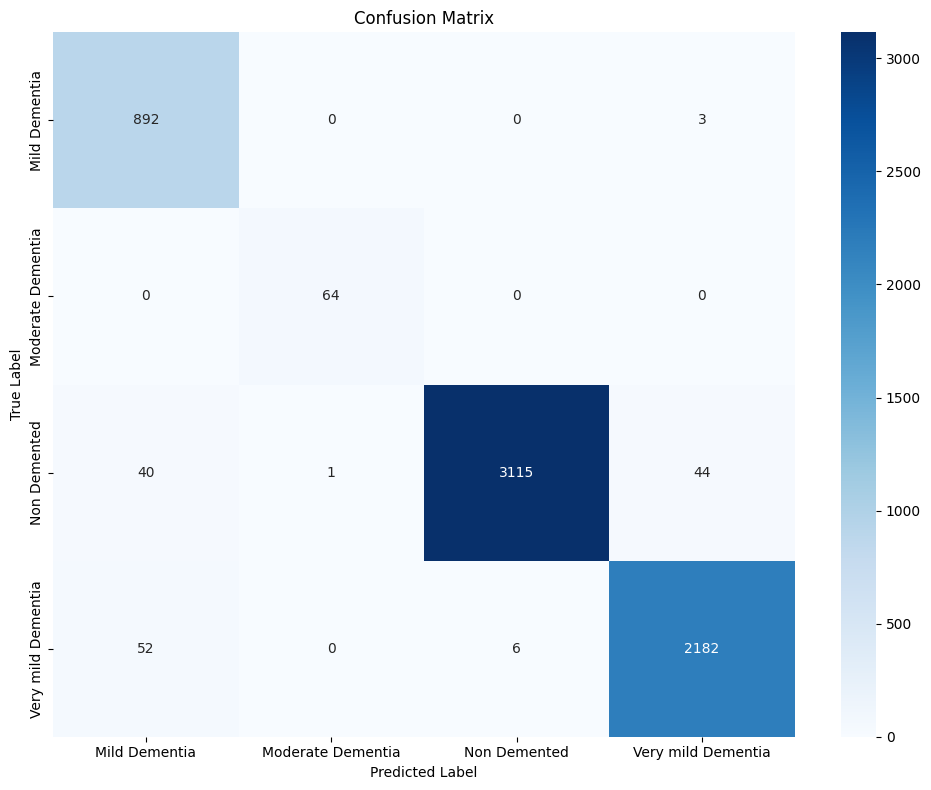

In [1]:
import tensorflow as tf
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# --- 1. SET YOUR PARAMETERS ---

# !! REPLACE THIS !!
# Path to the saved .keras model file
MODEL_FILE_PATH = '/kaggle/input/old-dataset-model/keras/default/1/best_oasis_model.keras'

# !! REPLACE THIS !!
# Path to the PARENT folder of your *labeled* test data.
# This folder should contain the subfolders for each class.
TEST_DATA_DIR = '/kaggle/input/adni-mendeley-dataset/Adni_mendeley_dataset/Adni_mendeley_dataset'


# --- Parameters from your notebook (Do not change) ---
IMG_HEIGHT = 180
IMG_WIDTH = 180
BATCH_SIZE = 32
CLASS_NAMES = [
    'Mild Dementia', 
    'Moderate Dementia', 
    'Non Demented', 
    'Very mild Dementia'
]

# --- 2. LOAD THE SAVED MODEL ---
print(f"Loading model from {MODEL_FILE_PATH}...")
try:
    model = tf.keras.models.load_model(MODEL_FILE_PATH)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# --- 3. LOAD THE LABELED TEST DATA ---
print(f"Loading labeled test data from {TEST_DATA_DIR}...")

try:
    # Load the dataset, this time with 'labels="inferred"' (the default)
    # Set shuffle=False to keep data and labels in order
    test_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=TEST_DATA_DIR,
        labels='inferred',
        label_mode='int',  # We want integer labels (0, 1, 2, 3)
        class_names=CLASS_NAMES, # Ensure order is correct
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        color_mode='rgb',  # Must be 'rgb' as required by the model
        batch_size=BATCH_SIZE,
        shuffle=False  # CRITICAL: Do not shuffle
    )
    
    print(f"Found {len(test_dataset.file_paths)} images in {len(test_dataset.class_names)} classes.")

    # --- 4. APPLY PREPROCESSING ---
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    
    # We map the dataset to apply the normalization
    # and also separate images (x) from labels (y)
    test_dataset_scaled = test_dataset.map(lambda x, y: (normalization_layer(x), y))

except Exception as e:
    print(f"Error loading images: {e}")
    print("Please check your TEST_DATA_DIR path and folder structure.")
    exit()


# --- 5. MAKE PREDICTIONS & GET TRUE LABELS ---

print("Making predictions on test set...")
# Predict on the entire scaled dataset
predictions = model.predict(test_dataset_scaled)

# Get the class with the highest probability (e.g., 0, 1, 2, or 3)
y_pred = np.argmax(predictions, axis=1)

# Get the true labels (y_true) from the dataset
# This concatenates the labels from all batches
y_true = np.concatenate([y for x, y in test_dataset], axis=0)


# --- 6. GENERATE CONFUSION MATRIX & REPORT ---

print("\n--- Classification Report ---")
# Print the classification report
report = classification_report(y_true, y_pred, target_names=CLASS_NAMES)
print(report)


print("\n--- Confusion Matrix ---")
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)


# --- 7. PLOT AND SAVE THE CONFUSION MATRIX ---
print("Generating confusion matrix plot...")
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

# Save the figure
plot_filename = 'confusion_matrix.png'
plt.savefig(plot_filename)
print(f"Confusion matrix plot saved as: {plot_filename}")